---

# Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
import seaborn as sns
import itertools
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

from sklearn.utils import all_estimators

from sklearn.preprocessing import LabelEncoder as le
from sklearn.preprocessing import MinMaxScaler as mms

from sklearn.linear_model import LinearRegression as lr

from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit as sss, train_test_split

from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score, fbeta_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score as acc_scr, r2_score, classification_report, confusion_matrix, make_scorer



---

# Functions

encode(df_copy, test_set=None, ordinal_cols=None, label_cols=None, float_cols=None, string_cols=None, int_cols=None, onehot_cols=None, concat_onehot=False, prefix_col=''):

In [2]:
def encode(df_copy, test_set=None, ordinal_cols=None, label_cols=None, float_cols=None, string_cols=None, int_cols=None, onehot_cols=None, concat_onehot=False, prefix_col=''):
    
    if type(test_set)==type(None): dfs = [df_copy.copy()]
    else: dfs = [df_copy.copy(), test_set.copy()]
    
    new_dfs = []
    for df in dfs.copy():

        if type(ordinal_cols)!=type(None):
            n_ordinals = len(ordinal_cols)
            for i, col in enumerate(ordinal_cols):
                ord_encoded_col = df[col].to_frame()
                df[col] = oe().fit(ord_encoded_col).transform(ord_encoded_col)
                clear_output(wait=True)
                print('Rotulando Variáveis Ordinais... - ', i, '/', n_ordinals)

        if type(label_cols)!=type(None):
            n_labels = len(label_cols)
            for i, col in enumerate(label_cols):

                label_encoded_col = df[col]
                df[col] = le().fit(label_encoded_col).transform(label_encoded_col)
                clear_output(wait=True)
                print('Rotulando Variáveis Categóricas... - ', i, '/', n_labels)

        if type(float_cols)!=type(None):
            n_floats = len(float_cols)
            for i, col in enumerate(float_cols):

                df[col] = df[col].astype(float)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "Float"... - ', i, '/', n_floats)

        if type(string_cols)!=type(None):         
            n_strings = len(string_cols)
            for i, col in enumerate(string_cols):

                df[col] = df[col].astype(str)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "String"... - ', i, '/', n_strings)

        if type(int_cols)!=type(None):         
            n_int = len(int_cols)
            for i, col in enumerate(int_cols):

                df[col] = df[col].astype(int)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "String"... - ', i, '/', n_int)

        if type(onehot_cols)!=type(None):         
            n_onehot = len(onehot_cols)
            onehot_lst = []
            for i, col in enumerate(onehot_cols):
                onehot_lst.append(pd.get_dummies(df[col], prefix=col+prefix_col))
                clear_output(wait=True)
                print('OneHot Encoding Variáveis... - ', i, '/', n_onehot)

            print('Concatenando Variáveis Onehot...')
            onehot_df = pd.concat(onehot_lst, axis=1)

            if concat_onehot: 
                print('Concatenando Dataframe OneHot...')
                df = pd.concat([df, onehot_df])
            else: 
                df = pd.concat([df.drop(onehot_cols, axis=1), onehot_df], axis=1)

        new_dfs.append(df.copy())
    
    if type(onehot_cols)!=type(None):
        if type(test_set)!=type(None):          
            keep_cols = list(set(new_dfs[0].columns).intersection(new_dfs[1].columns))
            new_dfs = [new_df[keep_cols] for new_df in new_dfs]
            
    return new_dfs

filtrar_categorias(df, target, ctgr_lst, replace_dict=None, encode=False)

In [3]:
def filtrar_categorias(df, target, ctgr_lst, replace_dict=None, encode=False):
    
    print('Construindo Index...')       # Selecionando index onde alvo em 'ctgr_lst'
    new_index=[]
    for ctgr in ctgr_lst:
        new_index += df[df[target]==ctgr].index.tolist()
    
    print('Extraindo Dados da Tabela...')      # Extraindo tabela com index construído
    df = df.loc[new_index]    
    
    if type(replace_dict)!=type(None):
        print('Substituindo Categorias: {}'.format(replace_dict))      # Fusão de categorias
        for key in replace_dict.keys():
            df[target] = df[target].replace(key, replace_dict[key])
    
    if encode:
        print('Rotulando Variável Alvo...')
        df[target] = le().fit(df[target]).transform(df[target])      # Rotulando variável alvo
        
    print('\nCategorias Atualizadas!')
    return df

scr_models(train_set, test_set=None, target='TX_RESP_Q050', models=None,
               names=None, params_list=None,
               method='classes', keep_params=False,
               clear=True, score_fbeta=False, betas=list(np.linspace(0,1,10)), triple=False)

In [4]:
def scr_models(train_set, test_set=None, target='TX_RESP_Q050', models=None,
               names=None, params_list=None,
               method='classes', keep_params=False,
               clear=True, score_fbeta=False, betas=list(np.linspace(0,1,10)), triple=False):
    
    n_models=len(models)
    if type(params_list)==type(None): params_list = [{}]*n_models

    rows = []
    cnt=1
    for model, name, params in zip(models, names, params_list):

        if clear: clear_output(wait=True)
        print('\nAvaliando Modelo {} - ({}/{})'.format(name, cnt, n_models))
        
        if triple:
                
            row = scr_triple(train_set, test_set, target, model, name, params, method, score_fbeta=score_fbeta, betas=betas)
        else:
        
            row = scr(train_set, test_set, target, model, name, params, method, score_fbeta=score_fbeta, betas=betas)
        
        rows.append(row)
        cnt+=1

    scrs_df = pd.concat(rows, axis=1).T
    if keep_params: 
        params_df = pd.DataFrame(params)
        scrs_df = pd.concat([scrs_df, params_df], axis=1)
        
    return scrs_df

scr(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={},
    method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10)), verbose=1)

In [5]:
def scr(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={}, method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10)), verbose=1):

    if verbose>=2: print('\nExtraindo X e Y...')
    features = [col for col in train_set.columns.tolist() if col!= target]
    x_train, y_train = train_set[features], train_set[target]
    if type(test_set) != type(None): x_test, y_test = test_set[features], test_set[target]

    scrs = []
    cols = [ 'accuracy',
             'matthews corrcoef',
             'precision - 0',
             'recall - 0',
             'f1-score - 0',
             'precision - 1',
             'recall - 1',
             'f1-score - 1',
             'precision - macro avg',
             'recall - macro avg',
             'f1-score - macro avg',
             'precision - weighted avg',
             'recall - weighted avg',
             'f1-score - weighted avg' ]

    if method=='cross_val_score': 
        print('Cross-Validating Model {}...'.format(name))
        scrs += cross_val_score(model(**params), x_train, y_train)
        cols = ['acc {}'.format(i) for i in range(1,6)]

    else:
        if verbose >= 1: print('\nConstruindo Modelo {}...'.format(name))
        new_model = model(**params)
        if verbose >= 1: print('Fitting...')
        new_model.fit(x_train, y_train)
        if verbose >= 1: print('Predicting...')
        y_pred = new_model.predict(x_test)
        if verbose >= 1: print('Scoring...')
        matthews = matthews_corrcoef(y_test, y_pred)        
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_scrs = [class_report['accuracy'], matthews] + list(class_report['0'].values())[:-1] + list(class_report['1'].values())[:-1] + list(class_report['macro avg'].values())[:-1] + list(class_report['weighted avg'].values())[:-1]
        
        scrs += class_scrs
 
    scrs = pd.Series(scrs, index=cols, name=name)
    
    if score_fbeta:
        beta_scrs = score_betas(y_test, y_pred, betas)
        beta_scrs.name=name
        scrs = pd.concat([scrs, beta_scrs], axis=0)
        
    return scrs
    

def scr_triple(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={}, method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10))):

    print('Extraindo X e Y...')
    features = [col for col in train_set.columns.tolist() if col!= target]
    x_train, y_train = train_set[features], train_set[target]
    if type(test_set) != type(None): x_test, y_test = test_set[features], test_set[target]

    scrs = []
    cols = [ 'accuracy',
             'matthews corrcoef',
             'precision - 0',
             'recall - 0',
             'f1-score - 0',
             'precision - 1',
             'recall - 1',
             'f1-score - 1',
             'precision - 2',
             'recall - 2',
             'f1-score - 2',
             'precision - macro avg',
             'recall - macro avg',
             'f1-score - macro avg',
             'precision - weighted avg',
             'recall - weighted avg',
             'f1-score - weighted avg' ]

    if method=='cross_val_score': 
        print('Cross-Validating Model {}...'.format(name))
        scrs += cross_val_score(model(**params), x_train, y_train)
        cols = ['acc {}'.format(i) for i in range(1,6)]

    else:
        print('Construindo Modelo {}...'.format(name))
        new_model = model(**params)
        print('Fitting...')
        new_model.fit(x_train, y_train)
        print('Predicting...')
        y_pred = new_model.predict(x_test)
        print('Scoring...')
        matthews = matthews_corrcoef(y_test, y_pred)        
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_scrs = [class_report['accuracy'], matthews] + list(class_report['0'].values())[:-1] + list(class_report['1'].values())[:-1] + list(class_report['2'].values())[:-1] + list(class_report['macro avg'].values())[:-1] + list(class_report['weighted avg'].values())[:-1]
        
        scrs += class_scrs
 
    scrs = pd.Series(scrs, index=cols, name=name)
    
    if score_fbeta:
        beta_scrs = score_betas(y_test, y_pred, betas)
        beta_scrs.name=name
        scrs = pd.concat([scrs, beta_scrs], axis=0)
        
    return scrs
    

feat_imp(df, target, test_size=0.2, random_state=None, n_models=1)

In [6]:
def feat_imp(df, target, test_size=0.2, random_state=None, n_models=1):

    feat_imp_models = [TREE, RFC, ETC, GBC, ABC][:n_models]
    feat_imp_names = ['TREE', 'RFC', 'ETC', 'GBC', 'ABC'][:n_models]
    
    y = df[target].copy()
    x = df.drop([target], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1-test_size), random_state=random_state)

    feat_cols = x_train.columns.tolist()
    scrs = []
    lst = []
    for i in range(len(feat_imp_models)):

        print('({}/{}) {}'.format(i, len(feat_imp_names), feat_imp_names[i]))
        print('Fitting...')
        model = feat_imp_models[i]().fit(x_train, y_train)
        print('Predicting...')
        y_pred = model.predict(x_test)
        print('Scoring...')
        acc = acc_scr(y_test, y_pred)

        feat_imps = model.feature_importances_.tolist()
        lst.append([feat_imp_names[i]]+feat_imps)
        scrs.append([feat_imp_names[i], acc])

        clear_output(wait=True)

    scrs_df = pd.DataFrame(scrs, columns=['model_name', 'acc']).set_index('model_name')
    feat_df = pd.DataFrame(lst, columns=['model_name'] + feat_cols).set_index('model_name')

    return scrs_df, feat_df

tune_model(df, target, model, params_dicts, retraining=None, random_state=4, clear=False, cross_val=False)

In [7]:
def tune_model(df, target, model, params_dicts, retraining=None, random_state=4, clear=False, cross_val=False):
        
    params_names = list(params_dicts[0].keys())

    if cross_val: 
        cols = ['scr {}'.format(i) for i in range((cv if type(cv)!=type(None) else 5))]
    else: 
        cols = ['acc']
        
    print('Extraindo variáveis alvo e independentes...')
    y = df[target]
    x = df.drop(target, axis=1)
    print('Dividindo amostras de treinamento e de teste...')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

    etc_scrs = []
    loop_size = len(params_dicts)
    cnt=0
    print('{}/{}'.format(cnt, loop_size))
    for params in params_dicts:
        
        params_values = list(params.values())
        
        print('Fitting...')
        new_model = model(**params)
        new_model.fit(x_train, y_train)
                
        if cross_val:
            print('Cross Validating Model...')
            acc = list(cross_val_score(new_model, x_test, y_test))
            
        else:
            print('Predicting...')
            y_pred = new_model.predict(x_test)
            print('Scoring...')
            acc = [acc_scr(y_test, y_pred)]
        
        
        etc_scrs.append(params_values+acc)

            
        cnt+=1
        if clear: clear_output(wait=True)
        print('{}/{}'.format(cnt, loop_size), params)

    etc_df = pd.DataFrame(etc_scrs, columns=params_names+cols)
    
    if type(retraining)!=type(None):
        etc_df = pd.concat([retraining, etc_df], axis=0)
    return etc_df

binary_sample(df, target, categories=[[0], [1]],
                  testing=[1000, 1000], training=[5000, 5000],
                  fill_train_1=False, equal_train_0=False,
                  test_set=None, print_shapes=False, invert=False)

In [8]:
def binary_sample(df, target, categories=[[0], [1]],
                  testing=[1000, 1000], training=[5000, 5000],
                  fill_train_1=False, equal_train_0=False,
                  test_set=None, print_shapes=False, invert=False):
    
    if invert:
        training=testing.copy()
        testing=[None, None]
    
    print('Extraindo Index por Categoria...')
    index_0 = df[df[target].isin(categories[0])].index
    index_1 = df[df[target].isin(categories[1])].index
        
    if type(test_set)==type(None):
        return_test=True
        print('Extraindo Index Teste - {} para {}...'.format(testing[0], testing[1]))
        test_index = list(np.random.choice(index_0, testing[0], replace=False)) + list(np.random.choice(index_1, testing[1], replace=False))
        print('Extraindo Tabela de Teste...')
        test_set = df.loc[test_index]
    
    else:
        return_test=False
        test_index = test_set.index.tolist()        
    
    print('Extraindo Index Treinamento (Excluindo Index Teste) - {} para {}...'.format(training[0], training[1]))  
    
    index_1_train = list(set(index_1).difference(test_index))   # Está Invertido (1 depois 0)
    if not fill_train_1: index_1_train = list(np.random.choice(index_1_train, training[1], replace=False))
    
    index_0_train = list(set(index_0).difference(test_index))
    if equal_train_0: training[0] = len(index_1_train)
    index_0_train = list(np.random.choice(index_0_train, training[0], replace=False))
    
    train_index = index_0_train + index_1_train
    
    print('Extraindo Tabela de Treinamento...')
    train_set = df.loc[train_index]    
        
    clear_output(wait=True)
    if print_shapes:
        print('Original Shape:')
        print(ano9_base.shape)
        print('Test Set Shape:')
        print(test_set.shape)
        print('Train Set Shape:')
        print(train_set.shape)
        print('')

    
    sets = [df, train_set, test_set]
    report_cols = ['Original', 'Treinamento', 'Teste']
    
    print('Contagem Abandono:')
    if invert: 
        report_cols[1], report_cols[2] = report_cols[2], report_cols[1]

    relatorio_amostragem = pd.concat([data_set[target]
                                      .value_counts()
                                      .to_frame()
                                      .rename(columns={target:col_name}) for data_set, col_name in zip(sets, report_cols)], axis=1)
    relatorio_amostragem.index=['Regular', 'Abandono']
    display(relatorio_amostragem)
   
    inter = set(train_set.index).intersection(test_set.index)
    if inter: print('\nInformação Vazada para Tabela de Treinamento')
    else: print('\nNenhum Aluno em Comum nas Tabelas de Treinamento e Teste')

    if not return_test: return train_set
    return train_set, test_set

size_opt(train_set, test_set, target, models, names, path, params={},
             min0=0.1, max0=1, min1=0.1, max1=1,
             n_cat0=10, n_cat1=10, degree_cat0=3, degree_cat1=2,
             history=[], cats_names=['Não Abandono', 'Abandono'], fbeta=None)

In [9]:
def size_opt(train_set, test_set, target, models, names, path, params={},
             min0=0.1, max0=1, min1=0.1, max1=1,
             n_cat0=10, n_cat1=10, degree_cat0=3, degree_cat1=3,
             history=[], cats_names=['Não Abandono', 'Abandono'], fbeta=None):

    y = train_set[target]
    cat0 = train_set[y==0]
    cat1 = train_set[y==1]
    cat0_index = cat0.index
    cat1_index = cat1.index
    len_cat0 = len(cat0)
    len_cat1 = len(cat1)
    len_train_set = len(train_set)
    
    rnd_gen = np.random.default_rng()

    for model, name in zip(models, names):

        cat0_loop = [int(i) for i in (np.linspace(min0 , max0, n_cat0)[:]**degree_cat0) * len_cat0 ]  
        cat1_loop = [int(i) for i in (np.linspace(min1, max1, n_cat1)[:]**degree_cat1) * len_cat1 ]

        n_iter = n_cat0 * n_cat1
        cnt = 0
        sizes_lst = []

        for sample_size_cat0 in cat0_loop:
            for sample_size_cat1 in cat1_loop:

                clear_output(wait=True)
                print('Proporção Categorias', '\nX0:', round(sample_size_cat0, 4), 'X1:', round(sample_size_cat1, 4), '-  {}/{}  ({}%)'.format(cnt, n_iter, round(cnt/n_iter*100, 2)))

                print('\nConstruindo index...')                
                sample_index = rnd_gen.choice(cat0_index, sample_size_cat0).tolist() + rnd_gen.choice(cat1_index, sample_size_cat1).tolist()

                print('Retirando Amostra...')
                train_set_sample = train_set.loc[sample_index]

                acc_df = scr(train_set_sample, test_set, target, model, name, params, method='classes')
                acc_df[cats_names[0]], acc_df[cats_names[1]] = sample_size_cat0, sample_size_cat1         
                
                index = acc_df.index
                new_index = index[-2:].tolist() + index[:-2].tolist()
                acc_df = acc_df[new_index]
                
                sizes_lst.append(acc_df)

                cnt+=1

        sizes_df = pd.concat(sizes_lst, axis=1).T
        history.append([name, sizes_df])
        sizes_df.to_csv(path.format(name))

    return history

### Visualization Functions

In [10]:
def report_2d(sizes_df, x='p', xlim=(-0.1, 10), ylim=(-0.05),  figsize=(15, 2), outcols=['support', 'support - 0', 'support - 1'], scatter=True, marker='o'):
    
    colors_report = [['blue', 'green'],
                     ['green', 'orange', 'red'],
                     ['green', 'orange', 'red'],
                     ['green', 'orange', 'red']]
    
    cols = pd.Series([col for col in sizes_df.columns[1:] if col not in [x] + outcols])
    fig, axs = plt.subplots(1,4, figsize=figsize)
    
    for i, col_index in enumerate([[1,2], [3,4,5], [6,7,8], [9,10,11]]):
        for col, color in zip(col_index, colors_report[i]):            
            
            if scatter:
                sizes_df.plot.scatter(x=x, y=cols[col], ax=axs[i], color=color)
        
            else:
                sizes_df.sort_values(x).plot(x=x, y=cols[col], ax=axs[i], color=color, marker=marker, ms=4)
        
        axs[i].set(xlim=xlim, ylim=ylim)
        axs[i].legend(cols[col_index])

    plt.show()
    plt.pause(0.01)

def make_grid(df, columns, verbose=1):

    xo, yo, zo = [df.loc[:, col] for col in columns]

    m, n = len(xo.unique()), len(yo.unique())

    xp = np.array(xo).reshape(m,n)
    yp = np.array(yo).reshape(m,n)
    zp = np.array(zo).reshape(m,n)
    
    if verbose==1:
        print('3D Grid:')
        print(xp.shape, yp.shape, zp.shape)
    
    return xp, yp, zp

def xyz_max(sizes_df, xy, z):
    max_df = sizes_df.groupby([xy[0]]).max()
    x_max = max_df.index
    z_max = max_df[z]
    y_max = sizes_df[sizes_df[z].isin(z_max.tolist())][xy[1]]
    print('2D Arrays:')
    print(x_max.shape, y_max.shape, z_max.shape)
    return  x_max, y_max, z_max

def projections(df, x, y, z, color='blue'):
    
    fig, axs = plt.subplots(1,2,figsize=(16,4))

    df.groupby(y).plot(x, z, ax=axs[0], color=color)
    df.groupby(x).plot(y, z, ax=axs[1], color=color)

    [axs[i].set(ylabel=z) for i in [0,1]]
    [axs[i].legend([]) for i in [0,1]]
    plt.show()

def scatter_3d(xs, ys, zs, rate=10, stop=0, method='simple', figsize=(10,6), alpha=0.7):
    
    for angle in range(0,360+stop,rate):

        fig = plt.figure(figsize=figsize)
        axs = fig.add_subplot(1,1,1,projection='3d')

        if method=='trisurf':
            axs.plot_trisurf(xs, ys,zs, alpha=alpha)
        else:
            axs.scatter(xs, ys, zs)
        
        axs.set(xlabel=xs.name, ylabel=ys.name, zlabel=zs.name)
        axs.view_init(8, angle)

        plt.show()
        plt.pause(0.01)
        clear_output(wait=True)

def scatter_2d(sizes_df, x, x_max=20, x_min=-0.5,  figsize=(17, 6), outcols=['support', 'support - 0', 'support - 1']):
    
    cols = [col for col in sizes_df.columns[1:] if col!=x and col not in [x] + outcols]
    fig, axs = plt.subplots(3,4, figsize=figsize)
    
    row, i = 0, 0
    for col in cols:
        if i==4: 
            i, row = 0, row+1

        sizes_df.plot.scatter(x=x, y=col, ax=axs[row][i])
        axs[row][i].set_xlim(-0.5, x_max)
        i+=1
    plt.show()
    plt.pause(0.01)

def plot_3d(xi, yi, zi, angle1=15, angle2=60, method='surface', zdir='z', cmap='coolwarm', norm=False, figsize=(7,4), labels=['X', 'Y', 'Z'], color='blue', alpha=1):
    
    if norm: norm = matplotlib.colors.Normalize()
    else: norm=None
    
    fig = plt.figure(figsize=figsize)
    axs = [fig.add_subplot(1,1,j,projection='3d') for j in [1]]

    if method=='surface': axs[0].plot_surface(yi, xi, zi, cmap=cmap, norm=norm, color=color, alpha=alpha)
    if method=='wireframe': axs[0].plot_wireframe(xi, yi, zi, cmap=cmap, color=color, alpha=alpha)
    if method=='contour':  axs[0].contour(xi, yi, zi, stride=1, zdir=zdir, color=color, alpha=alpha)

    [axs[k].view_init(angle1, angle2) for k in [0]]
    [axs[k].set(xlabel=labels[0], ylabel=labels[1], zlabel=labels[2]) for k in range(1)]
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)


def plot_3d_ontop(xyz_list, colors_list=None, alpha_list=None, method='surface', zdir='z', angle1=15, angle2=60, cmap=None, norm=False, figsize=(7,4)):
    
    if type(colors_list)==type(None): colors_list=[None]*len(xyz_list)
    if type(alpha_list)==type(None): alpha_list=[1]*len(xyz_list)
    
    if norm: norm = matplotlib.colors.Normalize()
    else: norm = None
    
    fig = plt.figure(figsize=figsize)
    axs = [fig.add_subplot(1,1,j,projection='3d') for j in [1]]
    
    for i, (xi, yi, zi) in enumerate(xyz_list):

        if method=='surface': axs[0].plot_surface(yi, xi, zi, color=colors_list[i], alpha=alpha_list[i], cmap=cmap, norm=norm)
        if method=='wireframe': axs[0].plot_wireframe(xi, yi, zi, alpha=0.7, cmap=cmap)
        if method=='contour':  axs[0].contour(xi, yi, zi, alpha=1, stride=1, zdir=zdir)

            
    [axs[k].view_init(angle1, angle2) for k in [0]]
    [axs[k].set(xlabel=xs.name, ylabel=ys.name, zlabel=zs.name) for k in range(1)]
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)


def rotate_3d(xyz, on_top=False, steps=(10,10), starts=(0,0), stops=(360,360), method='surface', zdir='z', colors_list=None, alpha_list=None, cmap=None, norm=False, figsize=(7,4), angle_var=7, labels=['X', 'Y', 'Z']):
    
    if not on_top: xi, yi, zi = xyz
    
    for angle1, angle2 in zip(range(starts[0], stops[1], steps[0]), range(starts[0], stops[0], steps[1])):
        
        if on_top: plot_3d_ontop(xyz, method=method, zdir=zdir, angle1=angle1/angle_var, angle2=angle2, colors_list=colors_list, alpha_list=alpha_list, cmap=cmap, norm=norm, figsize=figsize)
        
        else: plot_3d(xi, yi, zi, angle1=angle1/angle_var, angle2=angle2, method=method, zdir=zdir, figsize=figsize, labels=labels)


def full_plot_3d(xi, yi, zi, cmap='coolwarm', method='surface'):

    for angle, angle2 in zip(range(0,360,10), range(0, 360, int(10))):

        fig = plt.figure(figsize=(13,7))
        axs = [fig.add_subplot(2,2,j,projection='3d') for j in [1,2,3,4]]


        if method=='surface': axs[0].plot_surface(yi, xi, zi, alpha=1, cmap=cmap)

        else: axs[0].plot_wireframe(xi, yi, zi, alpha=0.7, cmap=cmap)

        axs[1].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='x',
                       offset=None)
        axs[2].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='y',
                       offset=None)
        axs[3].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='z',
                       offset=None)

        [axs[k].view_init(angle/7, angle) for k in [0,1,2,3]]
        [axs[k].set(xlabel='X', ylabel='Y', zlabel='Z') for k in range(4)]

        clear_output(wait=True)
        plt.show()
        plt.pause(0.001)
    #    if input()=='exit': break

---

# QUESTIONÁRIO SOCIO-ECONÔMICO DO ALUNO (ORIGINAL)'

#### Loading Raw Dataset

In [45]:
qst_raw = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Personal Work/Data Frames/Source/saep/CSV/saep_qst_aluno.csv').drop('Unnamed: 0', axis=1)

C:\Users\luisr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [38]:
qst_raw_copy = qst_raw.copy()
#qst_raw = qst_raw_copy.copy()

# Loading Adapted Data Dictionaries (questionaries' questions and alternatives texts)

In [87]:
dict_5ano = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\dicionários quest. alunos\dicionario 5ano.csv').set_index('questão')
dict_9ano = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\dicionários quest. alunos\dicionario 9ano.csv').set_index('questão')
dict_3ano = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\dicionários quest. alunos\dicionario 3ano.csv').set_index('questão')

---
# Limpeza dos Dados

### Coluna 10: "Turno"


In [39]:
print('Valores únicos da coluna "ID_TURNO":', qst_raw['ID_TURNO'].unique()); print('')
qst_raw['ID_TURNO'] = qst_raw['ID_TURNO'].replace(' ', -1).astype(int)

print('Contagem dos valores únicos:'),
qst_raw['ID_TURNO'].value_counts()

Valores únicos da coluna "ID_TURNO": ['2' '1' '3' ' ' 1 2 3]

Contagem dos valores únicos:


 2    536378
 1    466433
 3     42403
-1      3361
Name: ID_TURNO, dtype: int64

### Colunas "Questões"
1. Formatação nomes das colunas
2. Marcação de células vazias

#### Extracting Questions Columns

In [40]:
Q_columns = qst_raw.columns[15:]

In [40]:
for mark in ['*', ' ', '.']: qst_raw.replace(mark, np.nan, inplace=True)

In [41]:
respostas_unicas = np.unique(np.sum(np.array([qst_raw[col].unique().tolist() for col in Q_columns]))); respostas_unicas

<ipython-input-41-1e240f45b089>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  respostas_unicas = np.unique(np.sum(np.array([qst_raw[col].unique().tolist() for col in Q_columns])))


array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'nan'],
      dtype='<U32')

In [44]:
qst_raw.dropna(how='all', subset=Q_columns, inplace=True)

In [ ]:
vazios = qst_raw.isnull().mean()

vazios.plot.bar(figsize=(6,3), width=1)
plt.show()

In [46]:
qst_raw.replace(np.nan, '.', inplace=True)

In [54]:
out_cols = ['ID_SAEB', 'IN_SITUACAO_CENSO', 'IN_PREENCHIMENTO']

for col in out_cols:
    print(qst_raw[col].value_counts())

2011    849278
Name: ID_SAEB, dtype: int64
1    849278
Name: IN_SITUACAO_CENSO, dtype: int64
1    849278
Name: IN_PREENCHIMENTO, dtype: int64


In [56]:
qst_raw.drop(out_cols, inplace=True, axis=1)

# Salvando Questionário Socio-Econômico do Aluno Limpo

In [62]:
#qst_raw.to_csv('questionário_aluno_limpo.csv', index=False)   14/03/2021

In [21]:
qst_aluno = pd.read_csv('questionário_aluno_limpo.csv', index_col=0)#   14/03/2021

In [22]:
qst_all = qst_aluno.copy()

In [23]:
qst_aluno = qst_all[qst_all['ID_SERIE']==9]

In [15]:
qst_aluno.shape

(360455, 74)

---
# Loading Students Results

In [17]:
res_alun_final = pd.read_csv('resultado_aluno_limpo.csv', index_col=0)   #13/03/2021 (23:32)

In [20]:
res_alun_final

,ID_ALUNO,PESO,PROFICIENCIA_LP,DESVIO_PADRAO_LP,PROFICIENCIA_LP_SAEB,DESVIO_PADRAO_LP_SAEB,PROFICIENCIA_MT,DESVIO_PADRAO_MT,PROFICIENCIA_MT_SAEB,DESVIO_PADRAO_MT_SAEB
0,204320,1.200000,-0.543135,0.335023,220.061856,18.457544,-0.561132,0.324852,218.601407,18.156735
1,907687,1.200000,-2.067546,0.385162,136.076928,21.219870,-0.052366,0.355331,247.037523,19.860277
2,1611630,1.200000,-1.014258,0.350205,194.106106,19.293971,-0.817919,0.357318,204.248984,19.971335
3,1611631,1.200000,-1.528384,0.329361,165.781176,18.145605,-0.669903,0.313721,212.521943,17.534597
4,2313337,1.200000,-1.235317,0.320381,181.927222,17.650867,0.058611,0.368681,253.240286,20.606439
...,...,...,...,...,...,...,...,...,...,...
851837,2443665,0.969697,-1.377383,0.494121,174.100329,27.222788,-0.839460,0.358948,203.045007,20.062439
851838,3146034,0.969697,0.374586,0.349413,270.622192,19.250337,0.572627,0.393448,281.969837,21.990725
851839,3146035,0.969697,-0.639854,0.369123,214.733281,20.336227,-0.476210,0.395283,223.347896,22.093287
851840,3146036,0.969697,-1.445063,0.575705,170.371610,31.717524,-0.481049,0.472181,223.077433,26.391295


---
# Data Transformation

In [70]:
ids_cols = qst_aluno.columns[:12]; qst_cols = qst_aluno.columns[12:] 

target = 'TX_RESP_Q050' # Abandonment
features = [col for col in qst_aluno.columns if col!=target]

### Target Variable Conversion to Binary

In [25]:
qst_filt = filtrar_categorias(qst_aluno, target, ctgr_lst=['A', 'B', 'C'], replace_dict={'C':'B'}, encode=True) # (qst_aluno, target, ['A', 'B', 'C'])   # Eliminando questionários com reprovação vazia

Construindo Index...
Extraindo Dados da Tabela...
Substituindo Categorias: {'C': 'B'}
Rotulando Variável Alvo...

Categorias Atualizadas!


In [26]:
qst_aluno[target].value_counts()

A    326989
B     21818
C      6401
.      5247
Name: TX_RESP_Q050, dtype: int64

In [46]:
qst_filt[target].value_counts()

0    326989
1     28219
Name: TX_RESP_Q050, dtype: int64

### Optional: Adding Grade columns

In [47]:
qst_filt = pd.merge(qst_filt, res_alun_final, on='ID_ALUNO')

### Optional: Scaling Float Columns

In [67]:
float_cols = qst_filt.dtypes[qst_filt.dtypes==float].index

In [68]:
qst_filt[float_cols] = mms().fit_transform(qst_filt[float_cols])

### Encoding Feature Variables

In [71]:
qst_enc = encode(qst_filt, label_cols=features)[0]

Rotulando Variáveis Categóricas... -  72 / 73


In [72]:
qst_enc.dtypes.value_counts()

int32      62
int64      12
float64     9
dtype: int64

### Excluding Biased Features

In [73]:
new_features = [col for col in features + res_alun_final.columns.tolist() if col not in ['TX_RESP_Q004', 'ID_ALUNO', 'ID_SERIE']]

In [74]:
qst_final = qst_enc[[target] + new_features].copy()

#### Saving Encoded Data

In [30]:
#qst_final.to_csv('questionário_aluno_codificado.csv')

In [32]:
qst_final = pd.read_csv('questionário_aluno_codificado.csv', index_col=0)

# Models Evaluation

### Sampling

In [75]:
target = 'TX_RESP_Q050' # Reprovação
features = [col for col in qst_final.columns if col!=target]
new_features = [col for col in features if col not in ['TX_RESP_Q004', 'ID_ALUNO', 'ID_SERIE']]

In [76]:
train_set, test_set = binary_sample(qst_final, target, testing=[10000, 10000], training=[6000, 6000])

Contagem Abandono:


,Original,Treinamento,Teste
Regular,326976,6000,10000
Abandono,28217,6000,10000



Nenhum Aluno em Comum nas Tabelas de Treinamento e Teste


### Setting Models

In [56]:
classifiers = all_estimators('classifier')
models_dict = dict(classifiers)
names, models = list(models_dict.keys()), list(models_dict.values())

C:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [60]:
out = ['CategoricalNB', 'GaussianProcessClassifier', 'RadiusNeighborsClassifier', 'ClassifierChain', 'MultiOutputClassifier',
       'OneVsOneClassifier', 'OneVsRestClassifier', 'OutputCodeClassifier', 'StackingClassifier', 'VotingClassifier', 'LabelPropagation']

models = [model for model, name in zip(models, names) if name not in out]
names = [name for name in names if name not in out]
print(len(names), len(models), len(out), len(models_dict))

30 30 11 41


In [61]:
top_names = ['AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier',
             'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'RandomForestClassifier']
top_models = [models_dict[name] for name in top_names]

### Scoring

In [62]:
cls_scrs = ['accuracy', 'precision - 0', 'recall - 0', 'f1-score - 0', 'precision - 1', 'recall - 1', 'f1-score - 1', 'f1-score - macro avg']

In [77]:
scrs_label = scr_models(train_set, test_set, target, models, names); scrs_label.to_csv('preliminary_evaluation.csv')


Avaliando Modelo SVC - (30/30)

Construindo Modelo SVC...
Fitting...
Predicting...
Scoring...


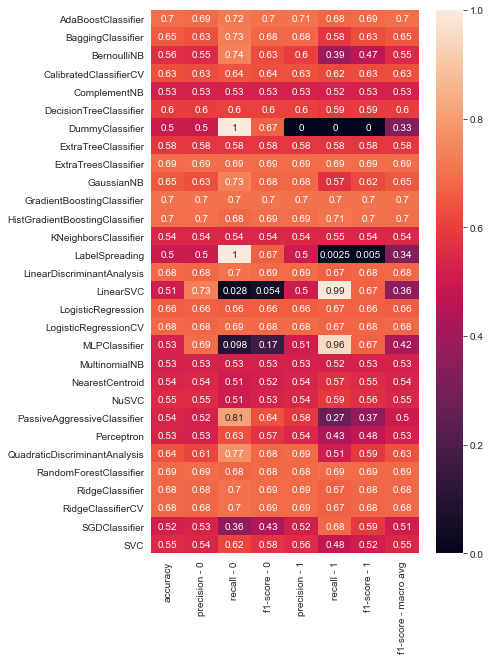

In [78]:
fig = plt.figure(figsize=(6,10)); sns.heatmap(scrs_label[cls_scrs], annot=True)

---
# Optimization - Unbalanced Classes Case

### Sampling

In [49]:
train_full, test_full = binary_sample(qst_final, target, testing=[5000, 5000], training=[30000, 30000])

Contagem Abandono:


,Original,Treinamento,Teste
Regular,214881,30000,5000
Abandono,139262,30000,5000



Nenhum Aluno em Comum nas Tabelas de Treinamento e Teste


### Grid Evaluation

In [196]:
opt_result = size_opt(train_full, test_full, target, top_models[:], top_names[:], 'size optimizations\{}.csv',
                      n_cat0=20, n_cat1=20, degree_cat0=2.5, degree_cat1=3,
                      cats_names=['Nunca Reprovou', 'Reprovou'], history=[])

Proporção Categorias 
X0: 30000 X1: 30000 -  399/400  (99.75%)

Construindo index...
Retirando Amostra...

Construindo Modelo RandomForestClassifier...
Fitting...
Predicting...
Scoring...


### Recarregando Histórico

In [70]:
sizes_history = []
path = 'size optimizations/{}.csv'
for name in top_names:
    sizes_history.append([name, pd.read_csv(path.format(name), index_col=0)])

In [71]:
dfs = [sizes_history[i][1] for i in range(len(sizes_history))]
x, y = 'Nunca Reprovou', 'Reprovou'
for i in range(len(dfs)):
    dfs[i]['p']=dfs[i][x]/dfs[i][y]

### Controle do modelo para Visualização:

In [55]:
print(dict(sizes_history).keys())
i = -1

dict_keys(['AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'RandomForestClassifier'])


In [56]:
i+=1
sizes_df = sizes_history[i][1]
sizes_df['p']=sizes_df['Nunca Reprovou']/sizes_df['Reprovou']

print('Modelo: {}'.format(sizes_history[i][0]))

Modelo: AdaBoostClassifier


### Extraindo x, y, z

In [57]:
xyz = ['Nunca Reprovou', 'Reprovou', 'accuracy']

x, y, z = xyz
xs, ys, zs = [sizes_df[col] for col in xyz]

sizes_df['p']=sizes_df[x]/sizes_df[y]

xp, yp, zp = make_grid(sizes_df, xyz)
x_max, y_max, z_max = xyz_max(sizes_df, [x,y], z)

3D Grid:
(10, 10) (10, 10) (10, 10)
2D Arrays:
(10,) (10,) (10,)


### Visualização

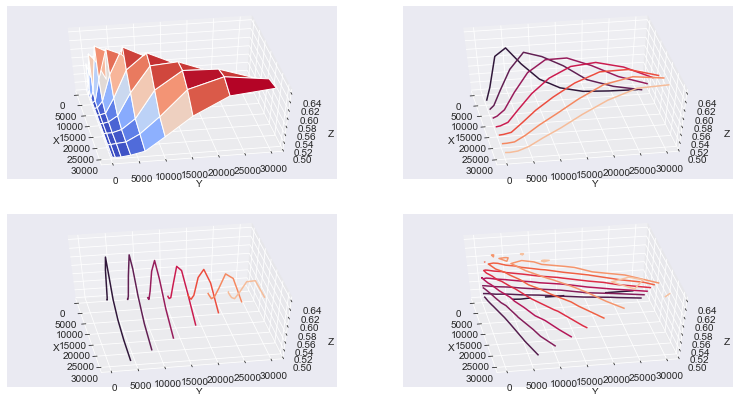

In [291]:
full_plot_3d(xp, yp, zp)

AdaBoostClassifier


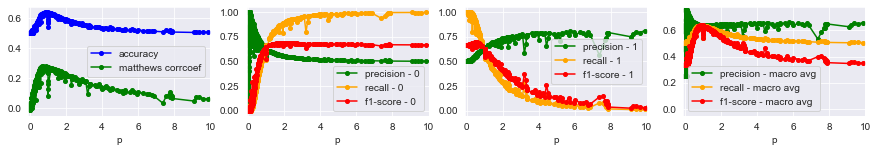

BaggingClassifier


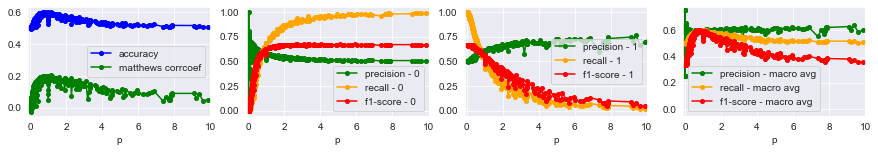

ExtraTreesClassifier


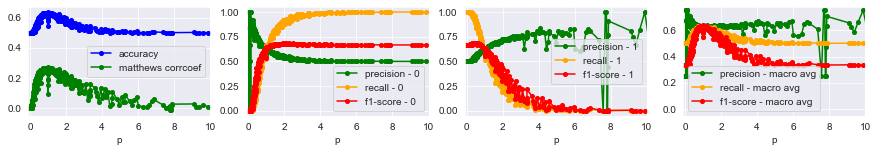

GradientBoostingClassifier


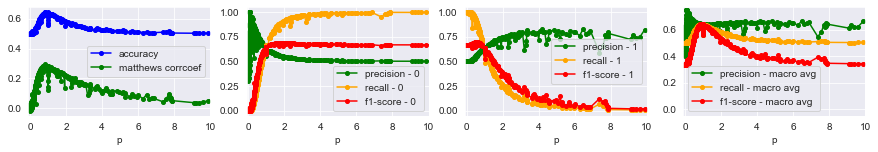

HistGradientBoostingClassifier


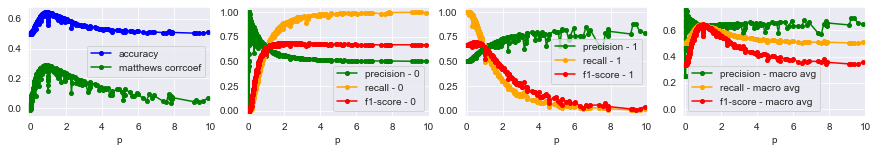

RandomForestClassifier


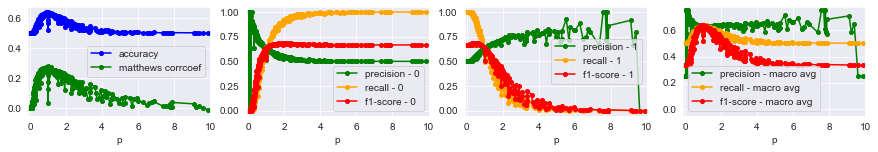

In [72]:
for df, name in zip(dfs, top_names):
    print(name)
    report_2d(df, 'p', scatter=False)

### Optimal proportions determination using Linear Regression

In [73]:
x, y = 'Nunca Reprovou', 'Reprovou'
base_variable = 'f1-score - weighted avg' # 'accuracy'

max_dfs = []
coefs = []
n = len(sizes_history)
for i in range(n):
    
    name = sizes_history[i][0]; sizes_df = sizes_history[i][1]; sizes_df['p']=sizes_df['Nunca Reprovou']/sizes_df['Reprovou']

    xs = sorted(sizes_df[x].unique().tolist())
    maximuns = []

    for x_i in xs:

        df_i = sizes_df[sizes_df[x]==x_i]; row_i = df_i[df_i[base_variable]==df_i[base_variable].max()]
        p_i, y_i, acc_i = row_i['p'][0], row_i[y][0], row_i[base_variable][0]

        maximuns.append((pd.Series([x_i, y_i, p_i, acc_i])))

    max_df = pd.concat(maximuns, 1).T; max_df.columns = [x, y, 'p', base_variable]; max_df['model']=name
    model = lr(fit_intercept=False).fit(max_df[[x]], max_df[[y]])
    
    r2 = r2_score(max_df[[y]], model.predict(max_df[[x]]))
    
    max_dfs.append(max_df); 
    coefs.append([name, model.coef_[0][0], r2])

    clear_output(wait=True)
    print(i+1, '/', n)
    
max_dfs = pd.concat(max_dfs, 0)
coefs = pd.DataFrame(coefs, columns=['model', 'a', 'r2']).set_index('model')

6 / 6


<ipython-input-97-55dbea71d5a4>:14: RuntimeWarning: invalid value encountered in true_divide
  ps.append((xi/yi)[0])
<ipython-input-97-55dbea71d5a4>:14: RuntimeWarning: invalid value encountered in true_divide
  ps.append((xi/yi)[0])
<ipython-input-97-55dbea71d5a4>:14: RuntimeWarning: invalid value encountered in true_divide
  ps.append((xi/yi)[0])
<ipython-input-97-55dbea71d5a4>:14: RuntimeWarning: invalid value encountered in true_divide
  ps.append((xi/yi)[0])
<ipython-input-97-55dbea71d5a4>:14: RuntimeWarning: invalid value encountered in true_divide
  ps.append((xi/yi)[0])
<ipython-input-97-55dbea71d5a4>:14: RuntimeWarning: invalid value encountered in true_divide
  ps.append((xi/yi)[0])


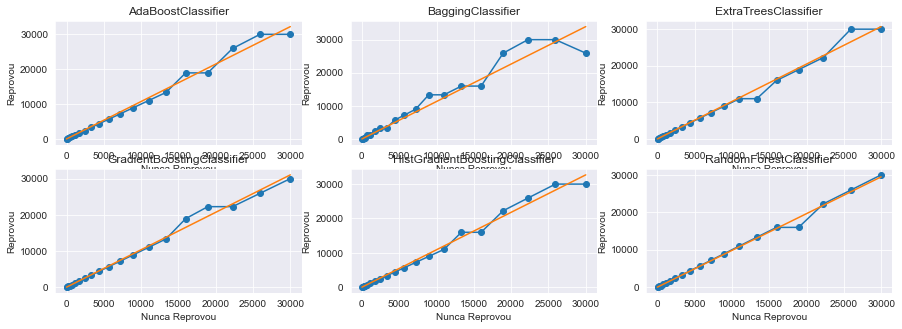

In [97]:
fig = plt.figure(figsize=(15,5)); axs = [fig.add_subplot(2,3,i+1) for i in range(6)]
ps = []
for i, model in enumerate(top_names):
    
    df = max_dfs[max_dfs['model']==model]
    axs[i].plot(df[x], df[y], marker='o')
        
    a = coefs.loc[model]['a']
    xi = np.linspace(0, 30000, 100)
    yi = a*xi
    axs[i].plot(xi, yi)
    axs[i].set(title=model, xlabel=x, ylabel=y)
    
    ps.append((xi/yi)[0])
    
plt.show()

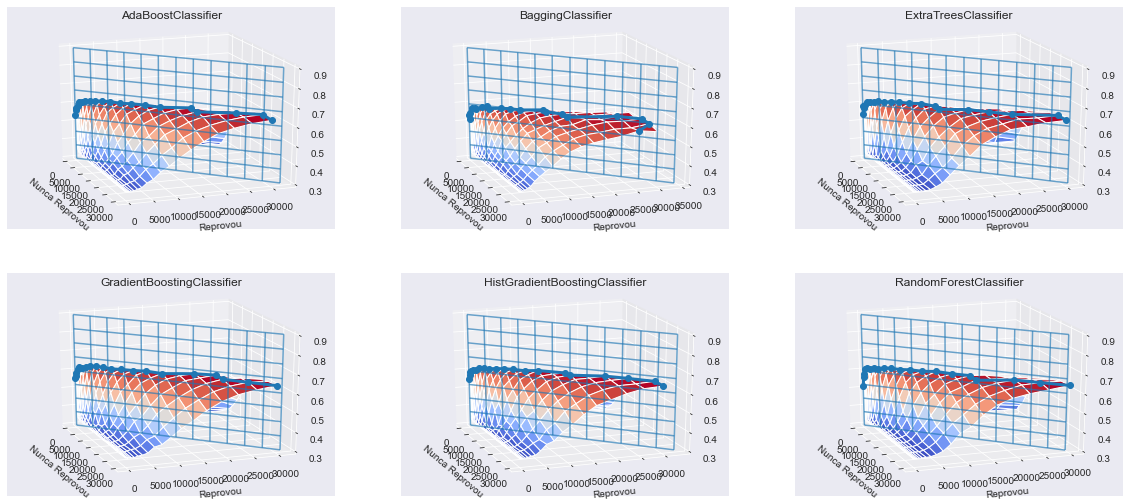

In [75]:
base_variable = 'f1-score - weighted avg'
ps = []
for angle in range(0, 360, 20):
    
    fig = plt.figure(figsize=(20,9)); axs = [fig.add_subplot(2,3,i+1, projection='3d') for i in range(6)]
    for i, model in enumerate(top_names):

        df = max_dfs[max_dfs['model']==model]   # Linha precisões máximas
        axs[i].plot(df[x], df[y], df[base_variable], lw=3, marker='o')

        a = coefs.loc[model]['a']
        xi = np.linspace(1, 30000, 25)
        yi = np.array([a*xi] * 25)
        zi = np.linspace(0.3, 0.9, 25)
        xgrid, zgrid = np.meshgrid(xi, zi)
        axs[i].plot_wireframe(xgrid, yi, zgrid, alpha=0.65, cstride=2, rstride=3)   # Planos verticais

        size_df = sizes_history[i][1]
        xs, ys, zs = make_grid(size_df, [x, y, base_variable], verbose=0)
        axs[i].plot_surface(xs, ys, zs, alpha=1, cmap='coolwarm')      # Precision Surface

        
        axs[i].set(title=model, xlabel=x, ylabel=y)
        ps.append((yi[0]/xi)[0])
        
        axs[i].view_init(20, angle)
    
    clear_output(wait=True)
    plt.pause(0.001)
    plt.show()
    

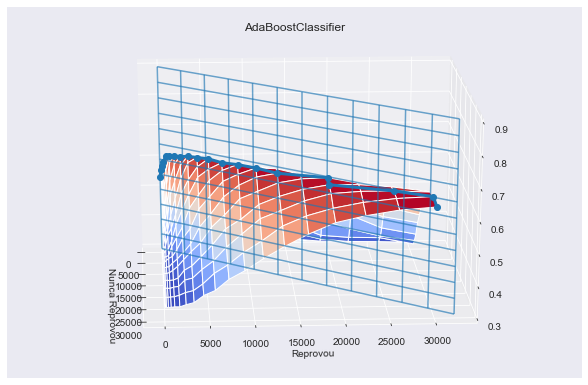

In [76]:
base_variable = 'f1-score - weighted avg'
[print([i, name]) for i, name in enumerate(top_names)]
control = int(input('Insira o índice para visualização'))

for angle in range(0, 360, 7):
    
    fig = plt.figure(figsize=(35, 15)); axs = fig.add_subplot(2,3,1, projection='3d')
    for i, model in enumerate(top_names):
        
        if i == control:

            df = max_dfs[max_dfs['model']==model]   # Linha precisões máximas
            axs.plot(df[x], df[y], df[base_variable], lw=3, marker='o')

            a = coefs.loc[model]['a']
            xi = np.linspace(1, 30000, 25)
            yi = np.array([a*xi] * 25)
            zi = np.linspace(0.3, 0.9, 25)
            xgrid, zgrid = np.meshgrid(xi, zi)
            axs.plot_wireframe(xgrid, yi, zgrid, alpha=0.65, cstride=2, rstride=2)   # Planos verticais

            size_df = sizes_history[i][1]
            xs, ys, zs = make_grid(size_df, [x, y, base_variable], verbose=0)
            axs.plot_surface(xs, ys, zs, alpha=1, cmap='coolwarm')


            axs.set(title=model, xlabel=x, ylabel=y)
            axs.view_init(20, angle)

    clear_output(wait=True)
    plt.pause(0.001)
    plt.show()
    

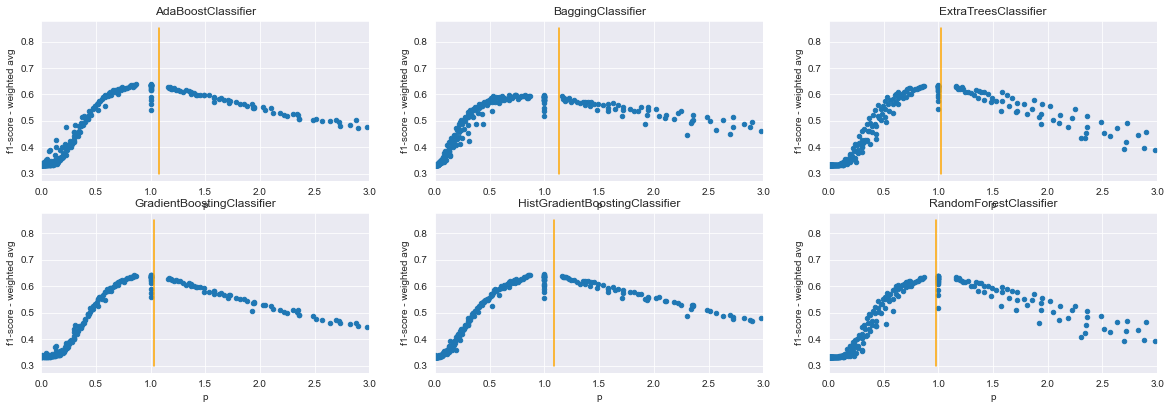

In [82]:
fig = plt.figure(figsize=(20,10)); axs = [fig.add_subplot(3,3,i) for i in range(1,7)]
k_i = np.linspace(0.3,0.85,25)

for i, df in enumerate(dfs):
    
    p_i = np.array([coefs['a'][i]]*25)
    axs[i].plot(p_i, k_i, color='orange')
    
      
    df.plot.scatter('p', base_variable, ax=axs[i]); axs[i].set(xlim=(0,3), title=sizes_history[i][0])

plt.show()

In [163]:
coefs

,a,r2
model,,
AdaBoostClassifier,1.073685,0.989179
BaggingClassifier,1.131542,0.940036
ExtraTreesClassifier,1.023335,0.988871
GradientBoostingClassifier,1.034584,0.991156
HistGradientBoostingClassifier,1.089563,0.989033
RandomForestClassifier,0.982358,0.995192


# Importance Charts

In [80]:
imp_names = ['AdaBoostClassifier',
 'ExtraTreesClassifier',
 'GradientBoostingClassifier',
 'RandomForestClassifier']

imp_models = [model for model, name in zip(top_models, top_names) if name in imp_names]

### Implicit importances

In [82]:
x_train, y_train = train_set[new_features], train_set[target]
x_test, y_test = test_set[new_features], test_set[target]

imps= []; i=0
for model, name in zip(imp_models, imp_names):

    i+=1; clear_output(wait=True); print('Fitting Model {}  -  {}/{}'.format(name, i, len(imp_names)))    
    imps.append(model().fit(x_train, y_train).feature_importances_)

imps_df = pd.DataFrame(imps, index=imp_names, columns=new_features)

Fitting Model RandomForestClassifier  -  4/4


### Teste chi2 e f-classif

In [83]:
X, Y = train_set[new_features], train_set[target]
chi = chi2(X, Y); f = f_classif(X, Y)
chi_df = pd.DataFrame(chi, columns=new_features, index=['chi2', 'p']).T.sort_values('chi2', ascending=False).head(10)
f_df = pd.DataFrame(chi, columns=new_features, index=['f_classif', 'p']).T.sort_values('f_classif', ascending=False).head(10)
imps_df = imps_df.append(f_df['f_classif'])
imps_df = imps_df.append(chi_df['chi2'])

C:\Users\luisr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [66 67 68 69] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\luisr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Bar Charts

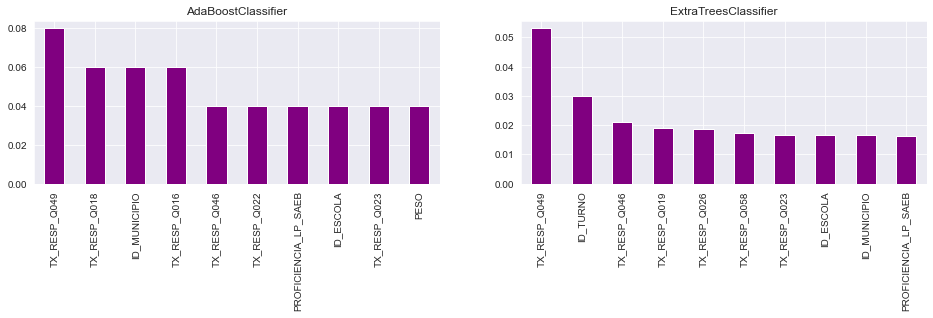

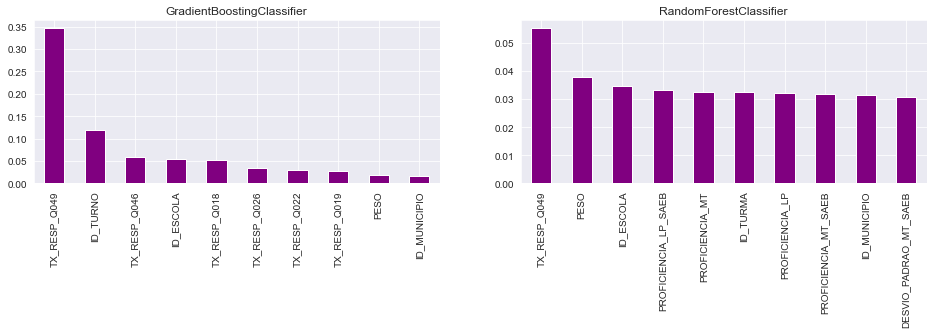

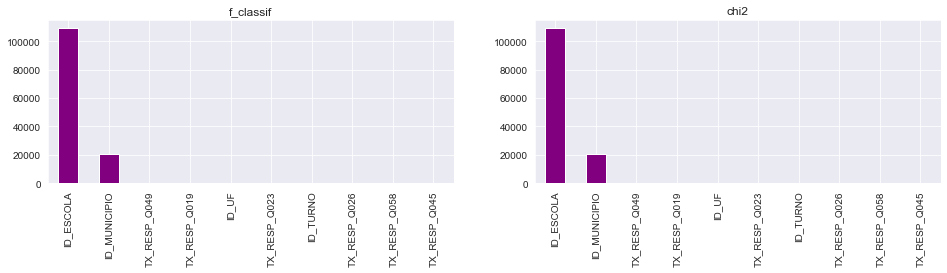

In [84]:
fig = plt.figure(figsize=(16,3))
axs = [fig.add_subplot(1,2,i) for i in range(1,3)]

i=0; stop=False; cnt=0
for model in imps_df.index:
    
    imps_df.loc[model].sort_values(ascending=False).head(10).plot.bar(ax=axs[i], color='purple')
    axs[i].set(title=model)
    i+=1; 

    if i in [2, 4] and not stop:
        i=0;
        cnt+=1; 
        if cnt==2: stop=True
        plt.show()
        fig = plt.figure(figsize=(16,3))
        axs = [fig.add_subplot(1,2,i) for i in range(1,3)]
    
plt.show()

### Selected Features

In [85]:
top_n = {}
head = 10

for n_ranks in reversed(range(3, 8)):
    top_features = {}
    for model in imps_df.index:
        top_features[model] = imps_df.loc[model].sort_values(ascending=False).head(head).index.tolist()

    inter_groups = []
    for index in list(itertools.combinations(range(6), n_ranks)):

        names = [imps_df.index[ind] for ind in index]
        set_0 = set(top_features[names[0]])
        for name in names[1:]: set_0 = set_0.intersection(top_features[name])


        inter_groups += list(set_0) #list(set(top_features[a]).intersection(set(top_features[b])).intersection(set(top_features[c])))

    inter_groups = list(set(inter_groups))
    top_n[n_ranks] = inter_groups

imp_result = pd.DataFrame(top_n.values(), index = top_n.keys()).T; imp_result

,7,6,5,4,3
0,None,ID_MUNICIPIO,ID_MUNICIPIO,TX_RESP_Q026,TX_RESP_Q026
1,None,TX_RESP_Q049,TX_RESP_Q049,TX_RESP_Q049,ID_MUNICIPIO
2,None,ID_ESCOLA,ID_ESCOLA,ID_MUNICIPIO,TX_RESP_Q049
3,None,None,None,TX_RESP_Q023,TX_RESP_Q023
4,None,None,None,ID_TURNO,TX_RESP_Q019
5,None,None,None,ID_ESCOLA,TX_RESP_Q058
6,None,None,None,TX_RESP_Q019,ID_TURNO
7,None,None,None,None,PESO
8,None,None,None,None,ID_ESCOLA
9,None,None,None,None,TX_RESP_Q046


In [88]:
dict_9ano.loc[[i for i in imp_result[3] if i in dict_9ano.index]]

,Enunciado,A,B,C,D,E,F,G,H,I,J,K,L
questão,,,,,,,,,,,,,
TX_RESP_Q026,Com que frequência seus pais ou responsáveis vão à reunião de pais?,Sempre ou quase sempre.,De vez em quando,Nunca ou quase nunca.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TX_RESP_Q049,Você já foi reprovado?,Não.,"Sim, uma vez.","Sim, duas vezes ou mais.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TX_RESP_Q023,Até que série seu pai ou o homem responsável por você estudou?,Nunca estudou.,Não completou a 4.ª série (antigo primário),"Completou a 4.ª série, mas não completou a 8.ª série (antigo ginásio).","Completou a 8.ª série, mas não completou o Ensino Médio (antigo 2.º grau).","Completou o Ensino Médio, mas não completou a Faculdade.",Completou a Faculdade.,Não sei.,NaN,NaN,NaN,NaN,NaN
TX_RESP_Q019,Até que série sua mãe ou a mulher responsável por você estudou?,Nunca estudou.,Não completou a 4.ª série (antigo primário),"Completou a 4.ª série, mas não completou a 8.ª série (antigo ginásio).","Completou a 8.ª série, mas não completou o Ensino Médio (antigo 2.º grau).","Completou o Ensino Médio, mas não completou a Faculdade.",Completou a Faculdade.,Não sei.,NaN,NaN,NaN,NaN,NaN
TX_RESP_Q058,"Quando você terminar o 9º ano(8ª série), você pretende:",Somente continuar estudando.,Somente Trabalhar.,Continuar estudando e trabalhar.,Ainda não sei.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TX_RESP_Q046,Você trabalha fora de casa?,Sim.,Não.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Selected Features Analyses

### Real Proportions

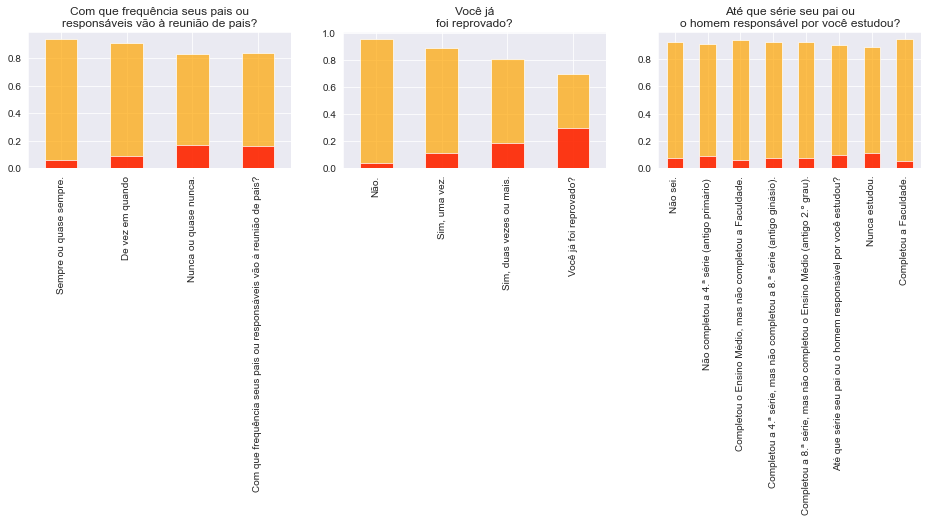

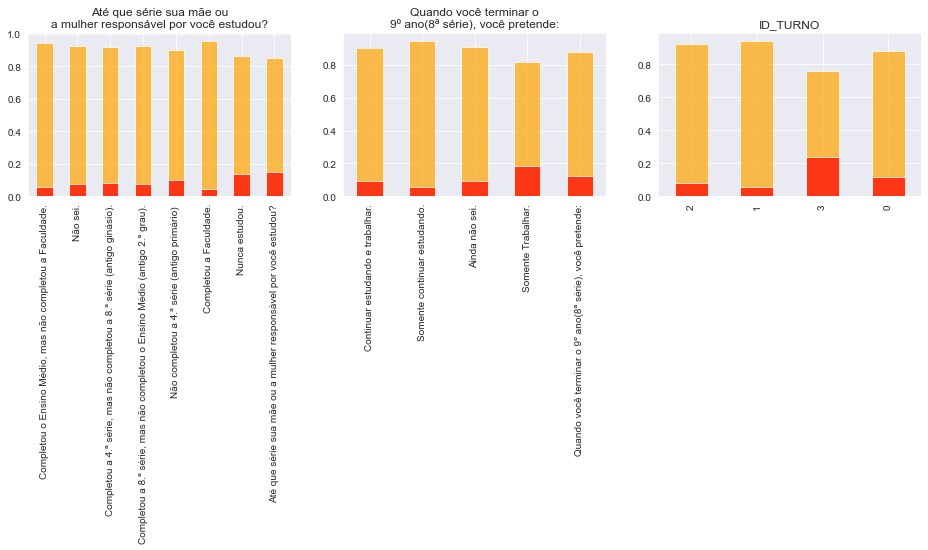

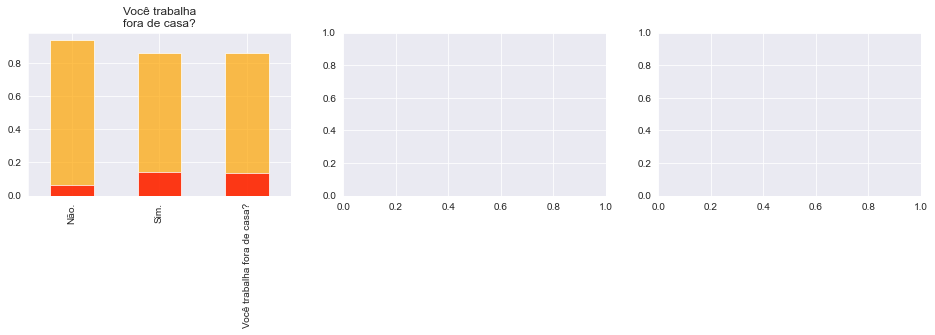

In [92]:
top_10 = imp_result[3].tolist()
top_dict = [question for question in top_10 if question in dict_9ano.index.tolist()]

totals = [qst_final[col].value_counts() for col in top_10]
not_rep = [qst_final[col][qst_final[target]==0].value_counts() for col in top_10]
rep = [qst_final[col][qst_final[target]==1].value_counts() for col in top_10]

not_rep_props = [not_rep[i]/totals[i] for i in range(len(top_10))]
rep_props = [(rep[i]/totals[i]).loc[not_rep_props[i].index] for i in range(len(top_10))]
#[print([len(i[j]) for j in range(len(top_10))]) for i in [totals, not_rep, rep, not_rep_props, rep_props]]

for name in top_dict:    
    
    i = top_10.index(name)
    
    rep_props[i].index = [dict_9ano.loc[name][index] if index!='.' else 'Sem Resposta' for index in  rep_props[i].index]
    rep_props[i].name = dict_9ano.loc[name]['Enunciado']
    
    not_rep_props[i].index = [dict_9ano.loc[name][index] if index!='.' else 'Sem Resposta' for index in  not_rep_props[i].index]
    not_rep_props[i].name = dict_9ano.loc[name]['Enunciado']

[not_rep_props, rep_props] = [ not_rep_props, rep_props]

fig = plt.figure(figsize=(16,2.5)); axs = [fig.add_subplot(1,3,i) for i in range(1, 4)]
cnt = 0; stop=False
for i in range(len(top_10)):
        
    if len(not_rep_props[i])<25:
        not_rep_props[i].plot.bar(color='orange', ax=axs[cnt], alpha=0.7)
        rep_props[i].plot.bar(color='red', ax=axs[cnt], alpha=0.7)
        
        title = rep_props[i].name.split()
        lt = int(len(title)/2)
        title = ' '.join(title[:lt]) + '\n' + ' '.join(title[lt:])
        axs[cnt].set_title(title)
        
        cnt+=1
    if cnt==3:
        cnt=0
        plt.show()
        plt.pause(0.01)
        if i==len(top_10)-1: break
        fig = plt.figure(figsize=(16,3)); axs = [fig.add_subplot(1,3,i) for i in range(1,4)]

plt.show()

### 50/50 Proportions

In [106]:
train_50, test_50 = binary_sample(qst_filt[[target]+new_features], target, testing=[28000, 28000], training=[1, 1])

Contagem Abandono:


,Original,Treinamento,Teste
Regular,326976,1,28000
Abandono,28217,1,28000



Nenhum Aluno em Comum nas Tabelas de Treinamento e Teste


In [107]:
top_10 = imp_result[3].tolist()
top_dict = [question for question in top_10 if question in dict_9ano.index.tolist()]

totals = [test_50[col].value_counts() for col in top_10]
not_rep = [test_50[col][test_50[target]==0].value_counts() for col in top_10]
rep = [test_50[col][test_50[target]==1].value_counts() for col in top_10]

not_rep_props = [not_rep[i]/totals[i] for i in range(len(top_10))]
rep_props = [(rep[i]/totals[i]).loc[not_rep_props[i].index] for i in range(len(top_10))]
#[print([len(i[j]) for j in range(len(top_10))]) for i in [totals, not_rep, rep, not_rep_props, rep_props]]

for name in top_dict:    
    
    i = top_10.index(name)
    
    rep_props[i].index = [dict_9ano.loc[name][index] if index!='.' else 'Sem Resposta' for index in  rep_props[i].index]
    rep_props[i].name = dict_9ano.loc[name]['Enunciado']
    
    not_rep_props[i].index = [dict_9ano.loc[name][index] if index!='.' else 'Sem Resposta' for index in  not_rep_props[i].index]
    not_rep_props[i].name = dict_9ano.loc[name]['Enunciado']

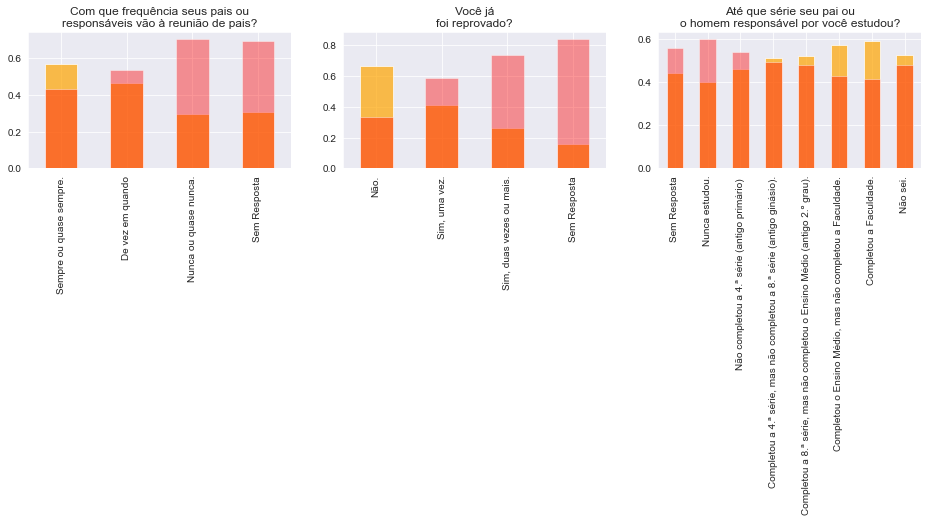

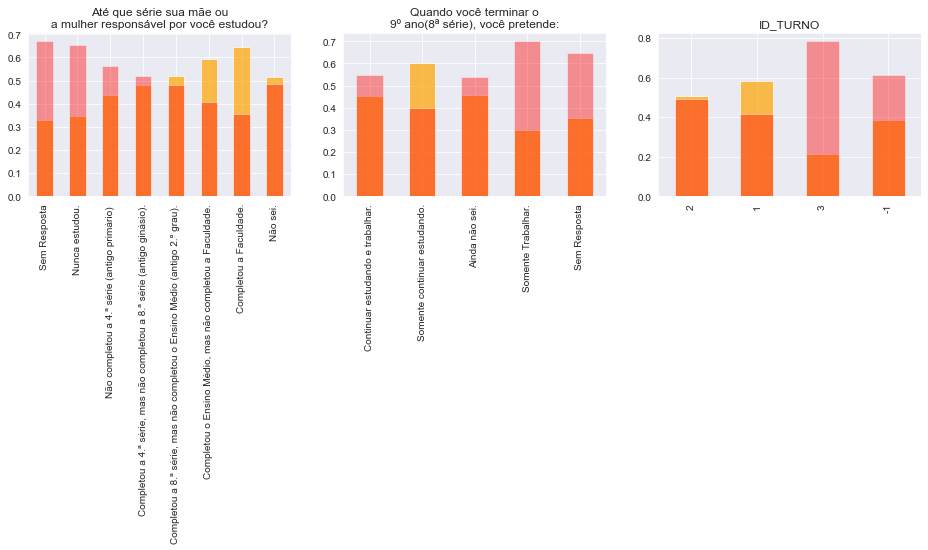

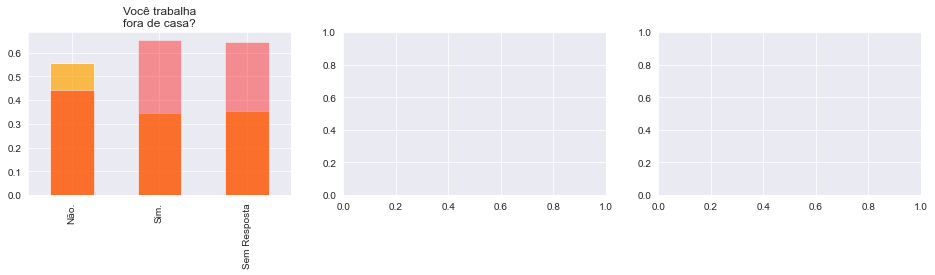

In [108]:
fig = plt.figure(figsize=(16,2.5)); axs = [fig.add_subplot(1,3,i) for i in range(1, 4)]
cnt = 0; stop=False
for i in range(len(top_10)):
        
    if len(not_rep_props[i])<25:
        not_rep_props[i].plot.bar(color='orange', ax=axs[cnt], alpha=0.7)
        rep_props[i].plot.bar(color='red', ax=axs[cnt], alpha=0.4)
        
        title = rep_props[i].name.split()
        lt = int(len(title)/2)
        title = ' '.join(title[:lt]) + '\n' + ' '.join(title[lt:])
        axs[cnt].set_title(title)
        
        cnt+=1
    if cnt==3:
        cnt=0
        plt.show()
        plt.pause(0.01)
        if i==len(top_10)-1: break
        fig = plt.figure(figsize=(16,3)); axs = [fig.add_subplot(1,3,i) for i in range(1,4)]

plt.show()

In [151]:
rep_freq = rep_props[1].value_counts().loc[rep_props[1].value_counts().index.sort_values(ascending=False)]


In [154]:
rep_freq

1.000000    14
0.923077     1
0.894737     1
0.888889     1
0.877551     1
            ..
0.153846     1
0.142857     2
0.133333     2
0.125000     4
0.111111     3
Name: ID_MUNICIPIO, Length: 409, dtype: int64

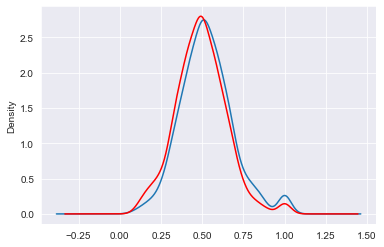

In [143]:
not_rep_props[1].plot.kde()
rep_props[1].plot.kde(color='red')

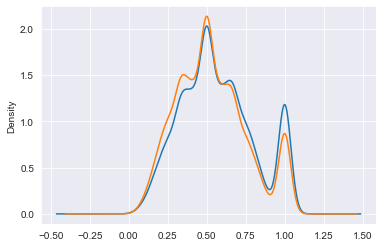

In [145]:
not_rep_props[-3].plot.kde()
rep_props[-3].plot.kde()

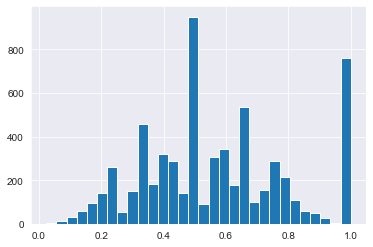

In [126]:
not_rep_props[-3].hist(bins=30)#.loc[not_rep_props[1].value_counts().index.sort_values(ascending=False)].plot()